<a href="https://colab.research.google.com/github/sejin-sim/Competitions/blob/main/%5BLecture%5D_2D_Materials_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 #### 기초 셋팅 : 그래프 한글 폰트 & 오류 문구 제거


In [ ]:
import numpy as np

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({"axes.grid" : True})

plt.rcParams["figure.figsize"] = (15,6)
plt.rc("font", size=18)  # 그림의 폰트 크기를 18로 고정

np.random.seed(42)
 
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
pip install pycaret[full]

In [ ]:
pip install Bayesian-Optimization

#### 데이터 설명

- 2D 물질 안정성 Database
- 147 개 Descriptor (Index 는 제외)
- 예측모델 2 개 : 
1. 예측값(regression) : decomposition_energy 
2. 분류(classification) : crystal_system

- Database: Train_Validation_Set.csv, 5539 개
- Database 로 예측모델 만든 후 , Testset.csv (616 개) 의 Descriptor 이용해서
- decomposition_energy 예측값 , crystal_system 예측값 




### EDA

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/인공지능/Train_Validation_Set.csv', index_col='Index')
test =  pd.read_csv('/content/drive/MyDrive/인공지능/Test_set_Unlabled.csv', index_col='Index')

In [ ]:
display(train)

NComp  Comp_L2Norm  ...  crystal_system  decomposition_energy
Index                      ...                                      
1          2     0.745356  ...        trigonal              0.300023
2          2     0.707107  ...       triclinic              0.177412
3          2     0.745356  ...        trigonal              0.485815
4          2     0.745356  ...        trigonal              0.237090
5          2     0.745356  ...        trigonal              0.011699
...      ...          ...  ...             ...                   ...
6149       2     0.849837  ...    orthorhombic              0.456139
6151       2     0.707107  ...        trigonal              0.389542
6152       2     0.707107  ...        trigonal              0.263491
6153       2     0.707107  ...        trigonal              0.183304
6154       2     0.707107  ...        trigonal              0.077500

[5539 rows x 149 columns]

In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5539 entries, 1 to 6154
Data columns (total 149 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   NComp                      int64  
 1   Comp_L2Norm                float64
 2   Comp_L3Norm                float64
 3   Comp_L5Norm                float64
 4   Comp_L7Norm                float64
 5   Comp_L10Norm               float64
 6   mean_Number                float64
 7   maxdiff_Number             int64  
 8   dev_Number                 float64
 9   max_Number                 int64  
 10  min_Number                 int64  
 11  most_Number                float64
 12  mean_MendeleevNumber       float64
 13  maxdiff_MendeleevNumber    int64  
 14  dev_MendeleevNumber        float64
 15  max_MendeleevNumber        int64  
 16  min_MendeleevNumber        int64  
 17  most_MendeleevNumber       float64
 18  mean_AtomicWeight          float64
 19  maxdiff_AtomicWeight       float64
 20  dev_Ato


147개의 feature 중 'mean_', 'maxdiff_', 'dev_', 'max_','min_', 'most_' 이름을 가진 feature들이 많다.


해당되는 feature의 갯수를 찾아보면 132개나 됨. 6가지 항목이 셋트라면, 22개의 본래 feature임을 알 수 있다.



In [ ]:
teatures = list(train.columns)

overlap = ['mean_', 'maxdiff_', 'dev_', 'max_','min_', 'most_']
cnt_mean_less = 0

for j in teatures:
  for i in overlap:
    if i in j:
      cnt_mean_less += 1

print("Numeric feature all : ", cnt_mean_less)
print("Numeric featrue set : ",cnt_mean_less/len(overlap))

Numeric feature all :  132
Numeric featrue set :  22.0


In [ ]:
train['crystal_system'].unique()

array(['trigonal', 'triclinic', 'tetragonal', 'monoclinic',
       'orthorhombic', 'hexagonal'], dtype=object)

target = 'trigonal', 'triclinic', 'tetragonal', 'monoclinic',
       'orthorhombic', 'hexagonal' 총 6개




In [ ]:
df = train[['crystal_system','decomposition_energy']]
df

crystal_system  decomposition_energy
Index                                     
1           trigonal              0.300023
2          triclinic              0.177412
3           trigonal              0.485815
4           trigonal              0.237090
5           trigonal              0.011699
...              ...                   ...
6149    orthorhombic              0.456139
6151        trigonal              0.389542
6152        trigonal              0.263491
6153        trigonal              0.183304
6154        trigonal              0.077500

[5539 rows x 2 columns]

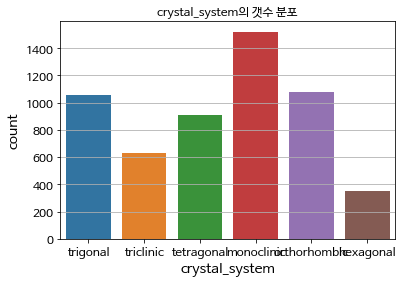

In [ ]:
ax = plt.subplots() 
ax = sns.countplot(x = df['crystal_system'], data=df['decomposition_energy']).set_title('crystal_system의 갯수 분포') 

target y multi class는 균형적으로 분포되어 있다.

In [ ]:
train['decomposition_energy'].groupby(train['crystal_system']).describe()

count      mean       std  ...       50%       75%       max
crystal_system                              ...                              
hexagonal        348.0  0.585829  0.550784  ...  0.469463  0.774577  3.378520
monoclinic      1521.0  0.168742  0.230763  ...  0.088907  0.209642  1.689834
orthorhombic    1078.0  0.294784  0.358509  ...  0.171855  0.410843  2.090000
tetragonal       907.0  0.342665  0.392329  ...  0.234486  0.467214  2.910404
triclinic        631.0  0.171550  0.207358  ...  0.108449  0.231464  2.118573
trigonal        1054.0  0.270531  0.382454  ...  0.148805  0.358993  3.469618

[6 rows x 8 columns]

In [ ]:
train.reset_index(drop=True)

NComp  Comp_L2Norm  ...  crystal_system  decomposition_energy
0         2     0.745356  ...        trigonal              0.300023
1         2     0.707107  ...       triclinic              0.177412
2         2     0.745356  ...        trigonal              0.485815
3         2     0.745356  ...        trigonal              0.237090
4         2     0.745356  ...        trigonal              0.011699
...     ...          ...  ...             ...                   ...
5534      2     0.849837  ...    orthorhombic              0.456139
5535      2     0.707107  ...        trigonal              0.389542
5536      2     0.707107  ...        trigonal              0.263491
5537      2     0.707107  ...        trigonal              0.183304
5538      2     0.707107  ...        trigonal              0.077500

[5539 rows x 149 columns]

In [ ]:
test.reset_index(drop=True)

NComp  Comp_L2Norm  Comp_L3Norm  ...  MeanIonicChar  bandgap_orig  sg_number
0        2     0.745356     0.693361  ...       0.243159        0.0000        164
1        2     0.824621     0.804145  ...       0.159319        0.0000        123
2        2     0.745356     0.693361  ...       0.346547        1.9866        164
3        2     0.790569     0.759147  ...       0.055446        1.0679         12
4        2     0.745356     0.693361  ...       0.340402        9.4494        164
..     ...          ...          ...  ...            ...           ...        ...
611      2     0.790569     0.759147  ...       0.047978        0.0000         99
612      2     0.707107     0.629961  ...       0.017728        0.0000         67
613      2     0.790569     0.759147  ...       0.075744        0.1424         99
614      2     0.745356     0.693361  ...       0.100046        0.0000         12
615      2     0.707107     0.629961  ...       0.040330        0.0248        156

[616 rows x 147 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder

train_cl_test = train.copy()

le = LabelEncoder()
train_cl_test['crystal_system'] = le.fit_transform(train_cl_test['crystal_system'])
train_cl_test

NComp  Comp_L2Norm  ...  crystal_system  decomposition_energy
0         2     0.745356  ...               5              0.300023
1         2     0.707107  ...               4              0.177412
2         2     0.745356  ...               5              0.485815
3         2     0.745356  ...               5              0.237090
4         2     0.745356  ...               5              0.011699
...     ...          ...  ...             ...                   ...
5534      2     0.849837  ...               2              0.456139
5535      2     0.707107  ...               5              0.389542
5536      2     0.707107  ...               5              0.263491
5537      2     0.707107  ...               5              0.183304
5538      2     0.707107  ...               5              0.077500

[5539 rows x 149 columns]

In [ ]:
corr_matrix_cl = train_cl_test.corr()
corr_matrix_cl['crystal_system'].sort_values(ascending=False)

crystal_system            1.000000
sg_number                 0.407351
most_NdUnfilled           0.095644
dev_NpValence             0.086798
most_GSvolume_pa          0.080237
                            ...   
max_NsUnfilled           -0.059135
maxdiff_NsUnfilled       -0.059374
most_Electronegativity   -0.061123
most_MendeleevNumber     -0.068244
min_NfUnfilled                 NaN
Name: crystal_system, Length: 149, dtype: float64

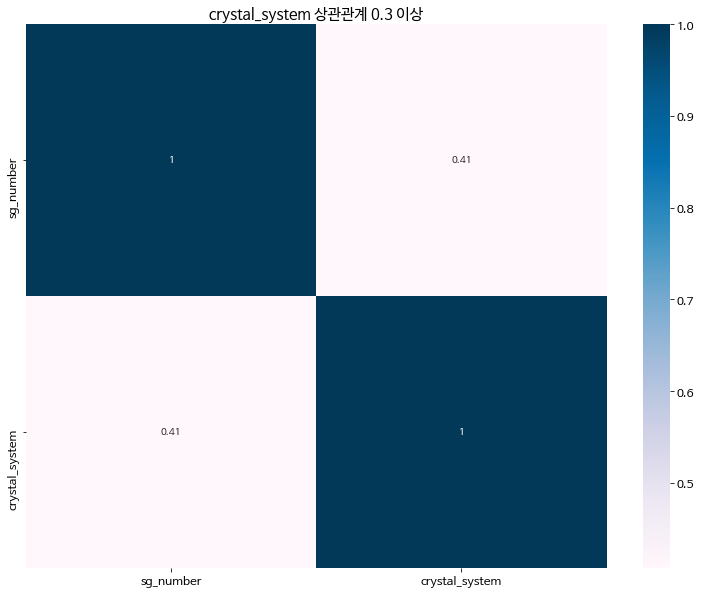

In [ ]:
colormap = plt.cm.PuBu

top_corr_matrix_cl = corr_matrix_cl.index[abs(corr_matrix_cl["crystal_system"])>=0.3]

# plot
plt.figure(figsize=(13,10))
g = sns.heatmap(train_cl_test[top_corr_matrix_cl].corr(), annot=True, cmap=colormap)
plt.title('crystal_system 상관관계 0.3 이상',size = 15)
plt.show()

In [ ]:
corr_matrix_rg = train.corr()
corr_matrix_rg["decomposition_energy"].sort_values(ascending=False)

decomposition_energy    1.000000
mean_MeltingT           0.428166
most_MeltingT           0.422389
min_MeltingT            0.345801
min_SpaceGroupNumber    0.331834
                          ...   
max_MendeleevNumber    -0.312837
mean_NpValence         -0.313965
maxdiff_NpValence      -0.336743
max_NpValence          -0.383712
min_NfUnfilled               NaN
Name: decomposition_energy, Length: 148, dtype: float64

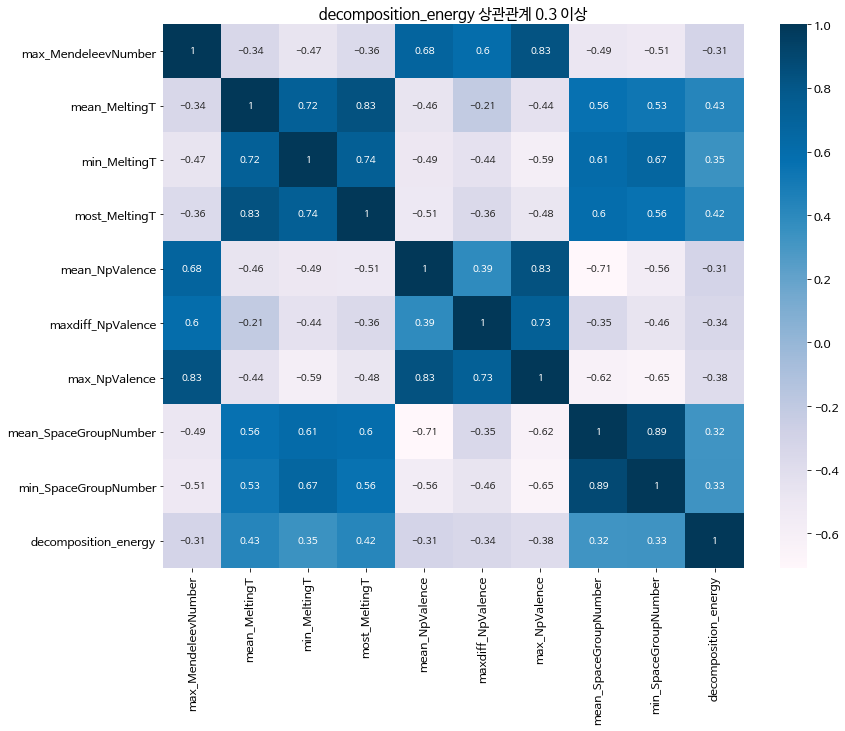

In [ ]:
colormap = plt.cm.PuBu

top_corr_matrix_rg = corr_matrix_rg.index[abs(corr_matrix_rg["decomposition_energy"])>=0.3] 

# plot
plt.figure(figsize=(13,10))
g = sns.heatmap(train[top_corr_matrix_rg].corr(), annot=True, cmap=colormap)
plt.title('decomposition_energy 상관관계 0.3 이상',size = 15)
plt.show()

In [ ]:
train_cl = train.drop('decomposition_energy', axis=1)
train_reg = train.drop('crystal_system', axis=1)

train_cl

NComp  Comp_L2Norm  Comp_L3Norm  ...  bandgap_orig  sg_number  crystal_system
0         2     0.745356     0.693361  ...        0.0000        164        trigonal
1         2     0.707107     0.629961  ...        0.9814          2       triclinic
2         2     0.745356     0.693361  ...        0.0000        166        trigonal
3         2     0.745356     0.693361  ...        0.0000        164        trigonal
4         2     0.745356     0.693361  ...        1.1619        164        trigonal
...     ...          ...          ...  ...           ...        ...             ...
5534      2     0.849837     0.835550  ...        0.0000         47    orthorhombic
5535      2     0.707107     0.629961  ...        0.0000        164        trigonal
5536      2     0.707107     0.629961  ...        0.0000        164        trigonal
5537      2     0.707107     0.629961  ...        0.0000        164        trigonal
5538      2     0.707107     0.629961  ...        0.0000        164        trigonal

[5539 rows x 148 columns]

In [ ]:
train_reg

NComp  Comp_L2Norm  ...  sg_number  decomposition_energy
0         2     0.745356  ...        164              0.300023
1         2     0.707107  ...          2              0.177412
2         2     0.745356  ...        166              0.485815
3         2     0.745356  ...        164              0.237090
4         2     0.745356  ...        164              0.011699
...     ...          ...  ...        ...                   ...
5534      2     0.849837  ...         47              0.456139
5535      2     0.707107  ...        164              0.389542
5536      2     0.707107  ...        164              0.263491
5537      2     0.707107  ...        164              0.183304
5538      2     0.707107  ...        164              0.077500

[5539 rows x 148 columns]

## Pycaret이란?
- Scikit-learn, XGBoost, LightGBM, spaCy 등 여러가지 머신러닝 라이브러리를 사용하기 용이하도록 ML High-Level API로 제작한 라이브러리
- Classification, Regression, Clustering 등 가능하다.
- 해당 프로젝트에서는 END TO END로 사용하지 않고 상위 모델을 일괄로 생성하는 기능으로 사용할 예정이다. (Score 정확도를 위해)

In [ ]:
#For Google Colab only
from pycaret.utils import enable_colab 

enable_colab()

Colab mode enabled.


## Classification Part

In [ ]:
from pycaret import classification

clf = classification.setup(train_cl, target = 'crystal_system', categorical_features=['sg_number'], fold = 5, use_gpu=True, session_id = 3180)

Description                                              Value
0                               session_id                                               3180
1                                   Target                                     crystal_system
2                              Target Type                                         Multiclass
3                            Label Encoded  hexagonal: 0, monoclinic: 1, orthorhombic: 2, ...
4                            Original Data                                        (5539, 148)
5                           Missing Values                                              False
6                         Numeric Features                                                109
7                     Categorical Features                                                 38
8                         Ordinal Features                                              False
9                High Cardinality Features                                              False
10                 High Cardinality Method                                               None
11                   Transformed Train Set                                        (3877, 433)
12                    Transformed Test Set                                        (1662, 433)
13                      Shuffle Train-Test                                               True
14                     Stratify Train-Test                                              False
15                          Fold Generator                                    StratifiedKFold
16                             Fold Number                                                  5
17                                CPU Jobs                                                 -1
18                                 Use GPU                                               True
19                          Log Experiment                                              False
20                         Experiment Name                                   clf-default-name
21                                     USI                                               7eb7
22                         Imputation Type                                             simple
23          Iterative Imputation Iteration                                               None
24                         Numeric Imputer                                               mean
25      Iterative Imputation Numeric Model                                               None
26                     Categorical Imputer                                           constant
27  Iterative Imputation Categorical Model                                               None
28           Unknown Categoricals Handling                                     least_frequent
29                               Normalize                                              False
30                        Normalize Method                                               None
31                          Transformation                                              False
32                   Transformation Method                                               None
33                                     PCA                                              False
34                              PCA Method                                               None
35                          PCA Components                                               None
36                     Ignore Low Variance                                              False
37                     Combine Rare Levels                                              False
38                    Rare Level Threshold                                               None
39                         Numeric Binning                                              False
40                         Remove Outliers                                              False
41                      Outliers Threshold                                         

In [ ]:
top5_cls = classification.compare_models(n_select = 5)

Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.9995  0.0000  0.9995  0.9995   
gbc          Gradient Boosting Classifier    0.9995  1.0000  0.9995  0.9995   
catboost              CatBoost Classifier    0.9987  1.0000  0.9989  0.9987   
dt               Decision Tree Classifier    0.9982  0.9988  0.9985  0.9982   
xgboost         Extreme Gradient Boosting    0.9961  1.0000  0.9949  0.9962   
nb                            Naive Bayes    0.9881  0.9970  0.9841  0.9883   
lightgbm  Light Gradient Boosting Machine    0.9801  0.9995  0.9789  0.9806   
qda       Quadratic Discriminant Analysis    0.9727  0.9846  0.9692  0.9765   
et                 Extra Trees Classifier    0.9657  0.9970  0.9671  0.9663   
rf               Random Forest Classifier    0.9175  0.9894  0.9145  0.9183   
lda          Linear Discriminant Analysis    0.5471  0.7795  0.5607  0.5541   
ada                  Ada Boost Classifier    0.5156  0.7309  0.5255  0.4206   
lr                    Logistic Regression    0.3753  0.6822  0.3113  0.3699   
knn                K Neighbors Classifier    0.3338  0.6402  0.2840  0.3243   
svm                   SVM - Linear Kernel    0.2592  0.0000  0.2164  0.2498   

              F1   Kappa     MCC  TT (Sec)  
ridge     0.9995  0.9994  0.9994     0.270  
gbc       0.9995  0.9994  0.9994    29.522  
catboost  0.9987  0.9984  0.9984    43.142  
dt        0.9982  0.9978  0.9978     0.386  
xgboost   0.9961  0.9952  0.9952     2.758  
nb        0.9881  0.9853  0.9853     0.072  
lightgbm  0.9802  0.9754  0.9754     2.710  
qda       0.9737  0.9662  0.9664     0.520  
et        0.9657  0.9574  0.9576     1.510  
rf        0.9173  0.8974  0.8977     1.608  
lda       0.5472  0.4339  0.4357     0.444  
ada       0.4174  0.3611  0.4810     1.178  
lr        0.3432  0.1955  0.2065     7.142  
knn       0.3202  0.1585  0.1611     0.892  
svm       0.1770  0.0699  0.0874     0.728

In [ ]:
# 모델별 하이퍼파라미터를 확인

for i in range(5):
  print(top5_cls[i])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=3180,
                solver='auto', tol=0.001)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3180, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, m

In [ ]:
top5_cls[2].get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [0, 1, 2, 3, 4, 5],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.0847880020737648,
 'loss_function': 'MultiClass',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 3180,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 

### Classification Top 5 model 점수 확인
- Pycaret으로는 validation score를 정확하게 확인하기가 어렵다고 판단
- cross_validate을 이용하여 train & vadlidation score를 확인 → 가장 좋은 model 선별 가능

In [ ]:
from sklearn.preprocessing import LabelEncoder      # category feature를 인코딩 해줌 (훈련을 위해)
from sklearn.model_selection import StratifiedKFold # 교차검증으로 라벨의 분포를 유지시켜줌
from sklearn.model_selection import cross_validate  # train & validation socre를 같이 반환

X = train_cl.drop('crystal_system', axis=1)
y = train_cl['crystal_system']

le = LabelEncoder()
trans_y = le.fit_transform(y)

for i in range(5):
  print("\n<{}>".format(type(top5_cls[i]).__name__))
  scores = cross_validate(top5_cls[i], X, trans_y, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)
  df = pd.DataFrame(scores)
  df.loc['mean'] = df.mean()
  display(df)


<RidgeClassifier>


fit_time  score_time  test_score  train_score
0     0.042226    0.019145    0.548736     0.601219
1     0.082450    0.013377    0.544224     0.609569
2     0.062604    0.014341    0.544224     0.604830
3     0.069499    0.013819    0.528881     0.604604
4     0.065164    0.013475    0.532972     0.598827
mean  0.064389    0.014832    0.539807     0.603810


<GradientBoostingClassifier>


fit_time  score_time  test_score  train_score
0     37.394547    0.020122    1.000000          1.0
1     37.336189    0.019556    1.000000          1.0
2     36.136101    0.018827    0.999097          1.0
3     35.945142    0.017207    0.999097          1.0
4     36.785886    0.019476    1.000000          1.0
mean  36.719573    0.019038    0.999639          1.0


<CatBoostClassifier>


fit_time  score_time  test_score  train_score
0     48.981071    0.013209    1.000000          1.0
1     49.739666    0.013804    1.000000          1.0
2     49.050116    0.013127    0.999097          1.0
3     48.058168    0.014081    0.999097          1.0
4     48.432715    0.013394    1.000000          1.0
mean  48.852347    0.013523    0.999639          1.0


<DecisionTreeClassifier>


fit_time  score_time  test_score  train_score
0     0.073820    0.004652    1.000000          1.0
1     0.065429    0.003258    1.000000          1.0
2     0.067922    0.003846    0.999097          1.0
3     0.066181    0.004624    0.999097          1.0
4     0.070108    0.004371    1.000000          1.0
mean  0.068692    0.004150    0.999639          1.0


<XGBClassifier>


fit_time  score_time  test_score  train_score
0     0.650112    0.005590    1.000000          1.0
1     0.624276    0.005501    1.000000          1.0
2     0.620342    0.005744    1.000000          1.0
3     0.621971    0.005540    0.999097          1.0
4     0.615228    0.005404    1.000000          1.0
mean  0.626386    0.005556    0.999819          1.0

### Classification Test score 결과 
- 스코어가 ridge 제외 거의 동일함으로 속도가 제일 빠른 **DecisionTreeClassifier**로 결정
- Test score가 최대치로 튜닝은 생략한다.

In [ ]:
cl_final_dt = top5_cls[3]

### Classification 모델 시각화 
- DecisionTreeClassifier 시각화 (pycaret 제공 시각화 그래프 & 결정 트리)

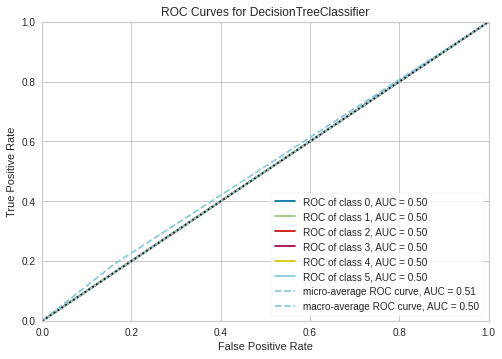

In [ ]:
classification.plot_model(cl_final_dt, plot = 'auc')

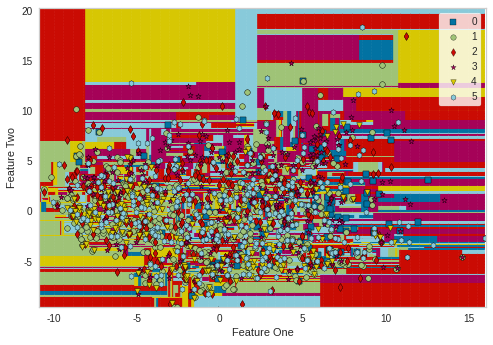

In [ ]:
classification.plot_model(cl_final_dt, plot = 'boundary') 

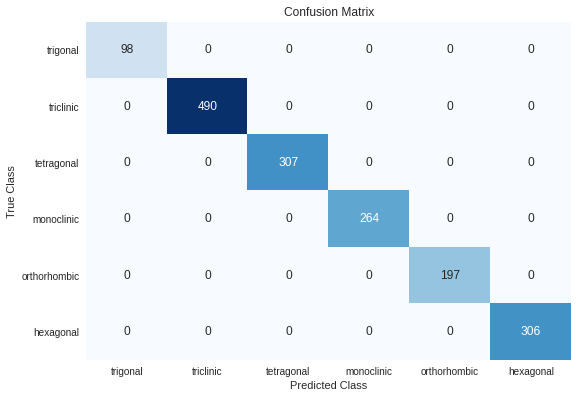

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

X = train_cl.drop('crystal_system', axis=1)
y = train_cl['crystal_system']
class_names = list(y.unique())

le = LabelEncoder()
trans_y = le.fit_transform(y)

features_train, features_test, target_train, target_test = train_test_split(X, trans_y, random_state=1, test_size = 0.3)
target_predicted = cl_final_dt.fit(features_train, target_train).predict(features_test)
matrix = confusion_matrix(target_test, target_predicted)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='d') # 히트맵 생성
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

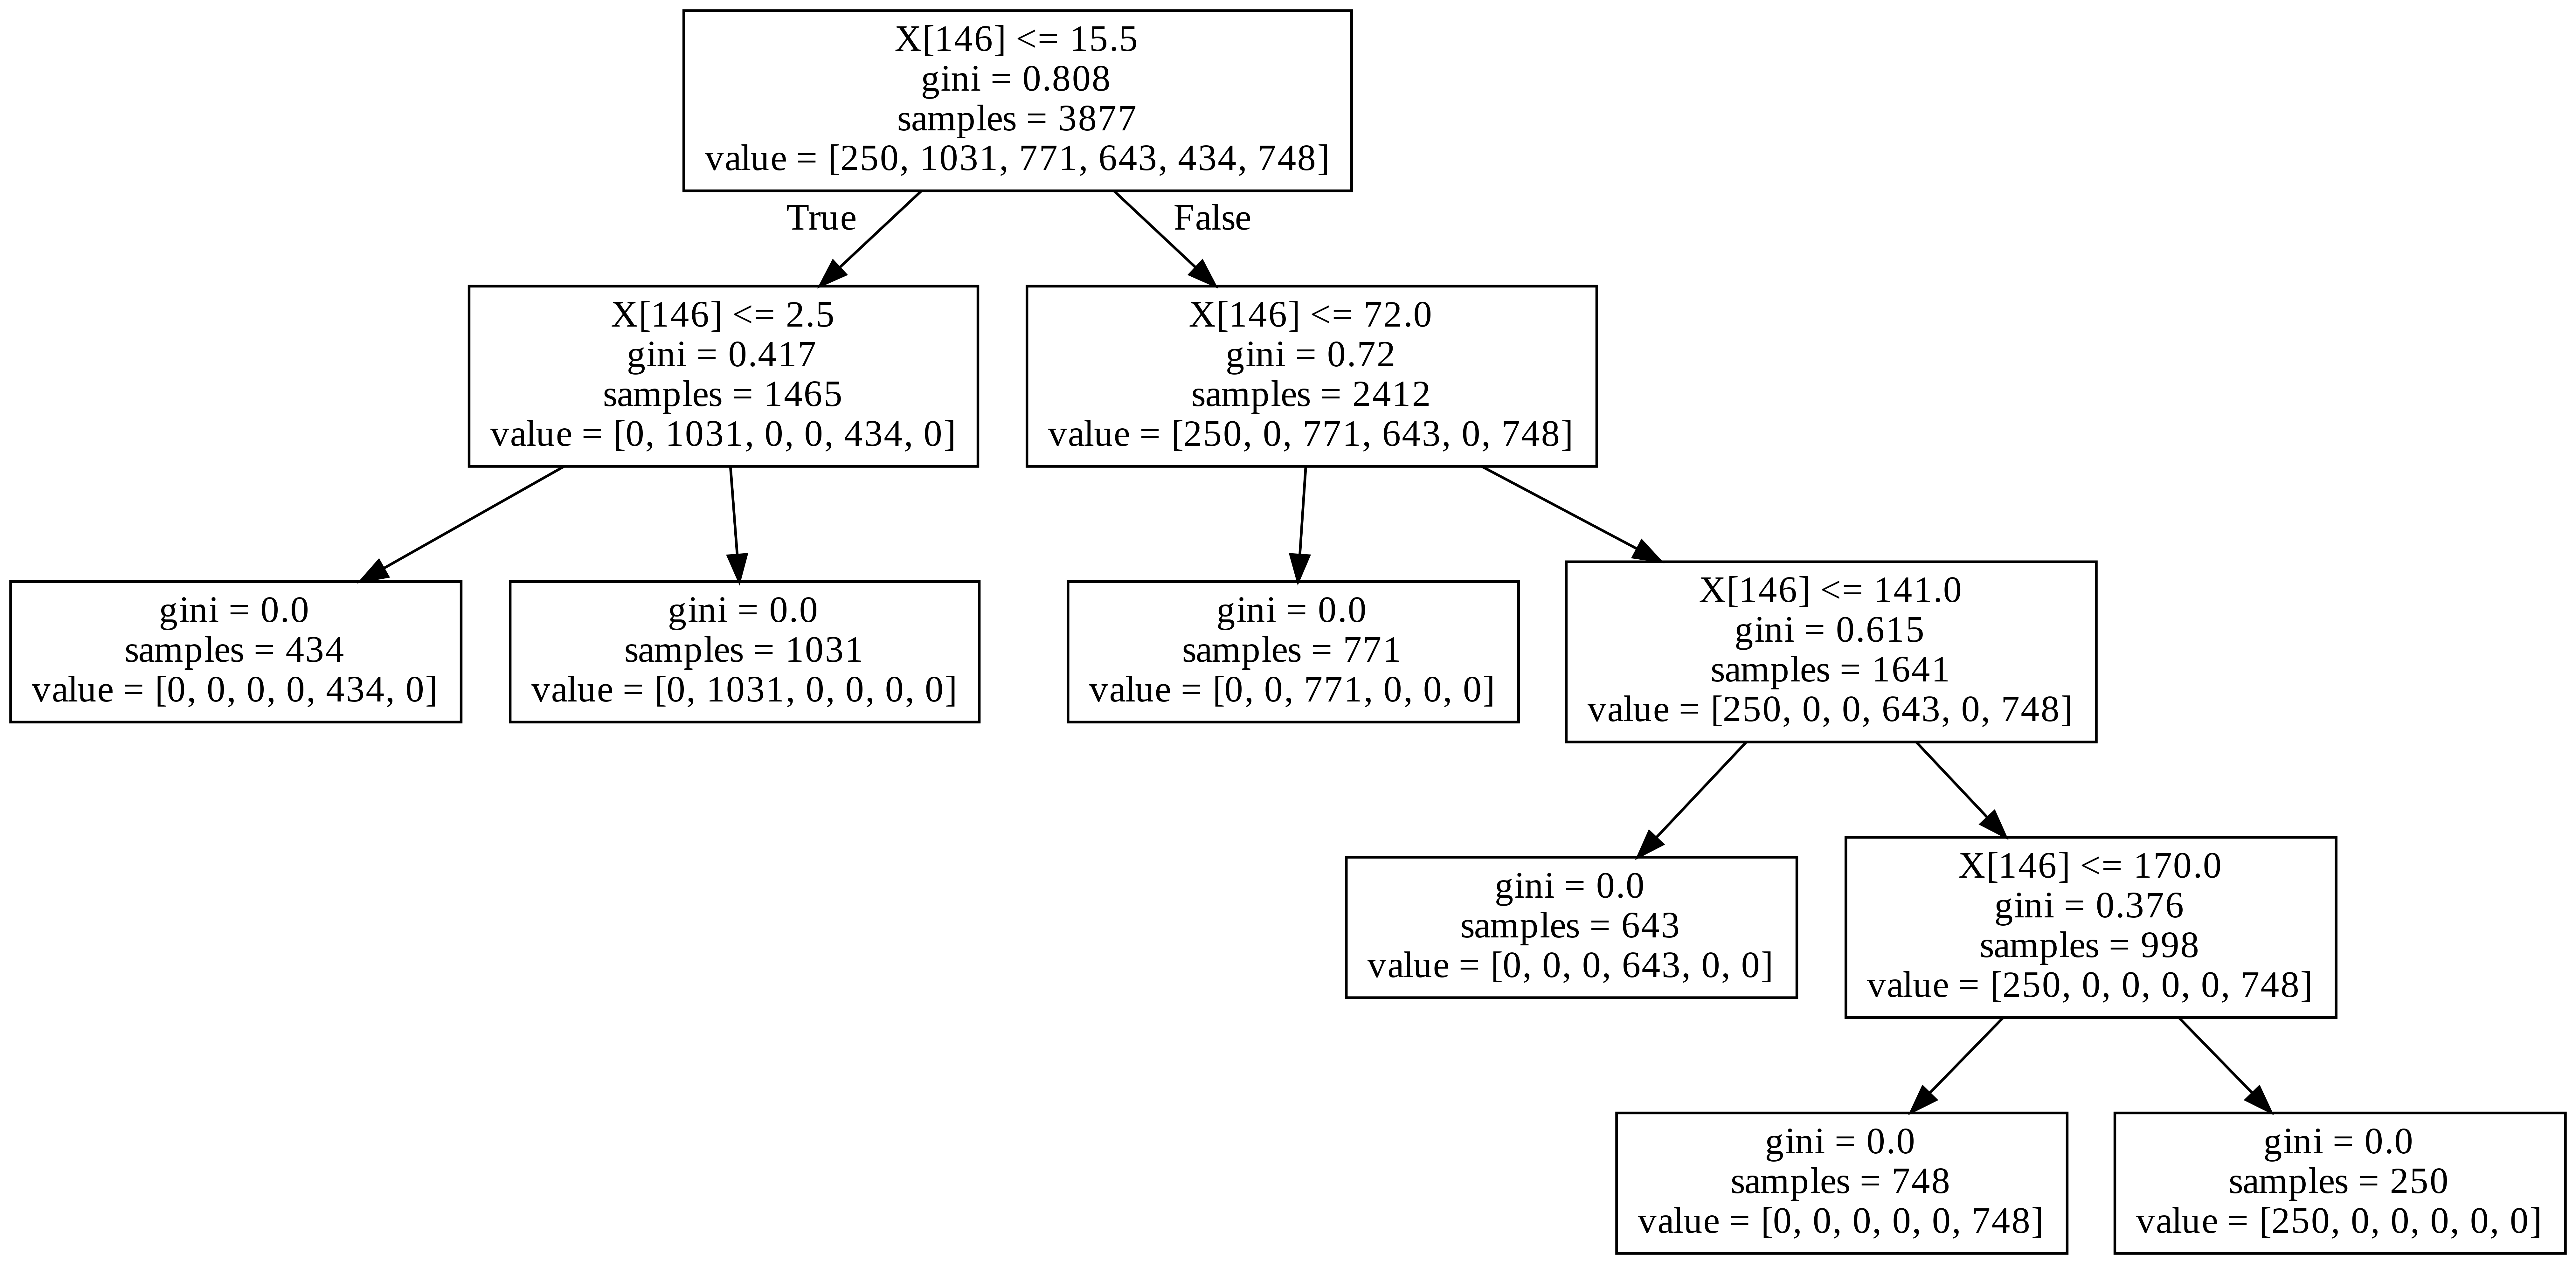

In [ ]:
# cl_final_dt predict 후 실행해야 함
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

export_graphviz(cl_final_dt, out_file='tree.dot')
call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])
Image(filename = 'decistion-tree.png')

### Classfication test set 예측

In [ ]:
cl_final_dt.fit(X, trans_y) 
y_cls_score = cl_final_dt.predict(test)
y_cls = le.inverse_transform(y_cls_score)
y_cls

array(['trigonal', 'tetragonal', 'trigonal', 'monoclinic', 'trigonal',
       'tetragonal', 'trigonal', 'trigonal', 'monoclinic', 'trigonal',
       'monoclinic', 'hexagonal', 'orthorhombic', 'orthorhombic',
       'orthorhombic', 'trigonal', 'tetragonal', 'trigonal', 'tetragonal',
       'trigonal', 'tetragonal', 'trigonal', 'orthorhombic',
       'orthorhombic', 'monoclinic', 'tetragonal', 'monoclinic',
       'trigonal', 'orthorhombic', 'triclinic', 'trigonal', 'triclinic',
       'trigonal', 'monoclinic', 'monoclinic', 'orthorhombic',
       'hexagonal', 'trigonal', 'monoclinic', 'monoclinic', 'monoclinic',
       'monoclinic', 'monoclinic', 'monoclinic', 'hexagonal',
       'monoclinic', 'trigonal', 'tetragonal', 'trigonal', 'trigonal',
       'trigonal', 'monoclinic', 'monoclinic', 'monoclinic',
       'orthorhombic', 'tetragonal', 'tetragonal', 'tetragonal',
       'monoclinic', 'trigonal', 'orthorhombic', 'tetragonal',
       'monoclinic', 'monoclinic', 'tetragonal', 'triclinic

## Regression Part

In [ ]:
from pycaret  import regression

reg = regression.setup(train_reg, target = 'decomposition_energy', categorical_features=['sg_number'], fold=5, use_gpu=True, session_id = 6023)

Description                 Value
0                               session_id                  6023
1                                   Target  decomposition_energy
2                            Original Data           (5539, 148)
3                           Missing Values                 False
4                         Numeric Features                   108
5                     Categorical Features                    39
6                         Ordinal Features                 False
7                High Cardinality Features                 False
8                  High Cardinality Method                  None
9                    Transformed Train Set           (3877, 436)
10                    Transformed Test Set           (1662, 436)
11                      Shuffle Train-Test                  True
12                     Stratify Train-Test                 False
13                          Fold Generator                 KFold
14                             Fold Number                     5
15                                CPU Jobs                    -1
16                                 Use GPU                  True
17                          Log Experiment                 False
18                         Experiment Name      reg-default-name
19                                     USI                  5ce1
20                         Imputation Type                simple
21          Iterative Imputation Iteration                  None
22                         Numeric Imputer                  mean
23      Iterative Imputation Numeric Model                  None
24                     Categorical Imputer              constant
25  Iterative Imputation Categorical Model                  None
26           Unknown Categoricals Handling        least_frequent
27                               Normalize                 False
28                        Normalize Method                  None
29                          Transformation                 False
30                   Transformation Method                  None
31                                     PCA                 False
32                              PCA Method                  None
33                          PCA Components                  None
34                     Ignore Low Variance                 False
35                     Combine Rare Levels                 False
36                    Rare Level Threshold                  None
37                         Numeric Binning                 False
38                         Remove Outliers                 False
39                      Outliers Threshold                  None
40                Remove Multicollinearity                 False
41             Multicollinearity Threshold                  None
42                              Clustering                 False
43                    Clustering Iteration                  None
44                     Polynomial Features                 False
45                       Polynomial Degree                  None
46                    Trignometry Features                 False
47                    Polynomial Threshold                  None
48                          Group Features                 False
49                       Feature Selection                 False
50                Feature Selection Method               classic
51            Features Selection Threshold                  None
52                     Feature Interaction                 False
53                           Feature Ratio                 False
54                   Interaction Threshold                  None
55                        Transform Target                 False
56                 Transform Target Method               box-cox

In [ ]:
top5_reg = regression.compare_models(n_select=5)

Model     MAE     MSE    RMSE      R2  \
et                  Extra Trees Regressor  0.1073  0.0407  0.2012  0.6803   
catboost               CatBoost Regressor  0.1174  0.0408  0.2018  0.6797   
xgboost         Extreme Gradient Boosting  0.1176  0.0447  0.2111  0.6493   
lightgbm  Light Gradient Boosting Machine  0.1223  0.0454  0.2128  0.6437   
rf                Random Forest Regressor  0.1222  0.0469  0.2163  0.6317   
gbr           Gradient Boosting Regressor  0.1457  0.0552  0.2348  0.5663   
ridge                    Ridge Regression  0.1685  0.0656  0.2560  0.4851   
br                         Bayesian Ridge  0.1658  0.0657  0.2563  0.4842   
lr                      Linear Regression  0.1719  0.0676  0.2600  0.4690   
omp           Orthogonal Matching Pursuit  0.1703  0.0705  0.2655  0.4462   
knn                 K Neighbors Regressor  0.1836  0.0845  0.2906  0.3365   
dt                Decision Tree Regressor  0.1513  0.0867  0.2936  0.3189   
en                            Elastic Net  0.2078  0.0959  0.3096  0.2471   
lasso                    Lasso Regression  0.2090  0.0979  0.3128  0.2315   
huber                     Huber Regressor  0.2134  0.0982  0.3132  0.2295   
llar         Lasso Least Angle Regression  0.2420  0.1274  0.3569 -0.0001   
ada                    AdaBoost Regressor  0.3460  0.1553  0.3937 -0.2200   
par          Passive Aggressive Regressor  0.3684  0.2673  0.4872 -1.1123   

           RMSLE          MAPE  TT (Sec)  
et        0.1222  5.478393e+10     7.304  
catboost  0.1248  7.050880e+10     9.984  
xgboost   0.1289  1.264098e+11     1.368  
lightgbm  0.1304  1.100822e+11     0.538  
rf        0.1321  1.735565e+11     9.510  
gbr       0.1475  2.862318e+11     4.734  
ridge     0.1617  8.779162e+10     0.164  
br        0.1604  1.484607e+11     0.400  
lr        0.1646  9.576163e+10     0.150  
omp       0.1666  3.588766e+11     0.052  
knn       0.1866  3.648964e+11     0.632  
dt        0.1776  5.535363e+10     0.366  
en        0.1998  2.359922e+11     0.146  
lasso     0.2019  1.767599e+11     0.100  
huber     0.2008  2.058047e+11     1.310  
llar      0.2277  2.670781e+11     0.046  
ada       0.2819  5.946016e+11     2.392  
par       0.2865  5.114118e+11     0.108

In [ ]:
for i in range(5):
  print(top5_reg[i])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=6023, verbose=0, warm_start=False)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=6023, reg_alpha=0,
             reg_lambda=1, scal

In [ ]:
top5_reg[1].get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.04967699944972992,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 6023,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.8000000119209

### Regression Top 5 model 점수 확인

In [ ]:
from sklearn.model_selection import KFold  
from sklearn.model_selection import cross_validate

X = train_reg.drop('decomposition_energy', axis=1)
y = train_reg['decomposition_energy']

for i in range(5):
  print("\n<{}>".format(type(top5_reg[i]).__name__))
  scores = cross_validate(top5_reg[i], X, y, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv=KFold(n_splits=5, shuffle=True), return_train_score=True)
  df = pd.DataFrame(scores)
  df.loc['mean'] = df.mean()
  display(df)


<ExtraTreesRegressor>


fit_time  ...  train_neg_mean_squared_error
0     4.577570  ...                     -0.000032
1     4.479672  ...                     -0.000028
2     4.555676  ...                     -0.000011
3     4.555700  ...                     -0.000027
4     4.574426  ...                     -0.000038
mean  4.548609  ...                     -0.000027

[6 rows x 8 columns]


<CatBoostRegressor>


fit_time  ...  train_neg_mean_squared_error
0     10.466156  ...                     -0.007239
1     10.388859  ...                     -0.007557
2     10.384725  ...                     -0.008035
3     10.365164  ...                     -0.008142
4     10.288378  ...                     -0.008304
mean  10.378657  ...                     -0.007855

[6 rows x 8 columns]


<XGBRegressor>


fit_time  ...  train_neg_mean_squared_error
0     0.676078  ...                     -0.001848
1     0.654786  ...                     -0.001867
2     0.668164  ...                     -0.001863
3     0.664846  ...                     -0.002111
4     0.661509  ...                     -0.001647
mean  0.665076  ...                     -0.001867

[6 rows x 8 columns]


<LGBMRegressor>


fit_time  ...  train_neg_mean_squared_error
0     0.537153  ...                     -0.011167
1     0.567701  ...                     -0.011054
2     0.551481  ...                     -0.011622
3     0.533170  ...                     -0.011245
4     0.566243  ...                     -0.011211
mean  0.551150  ...                     -0.011260

[6 rows x 8 columns]


<RandomForestRegressor>


fit_time  ...  train_neg_mean_squared_error
0      9.974030  ...                     -0.005803
1     10.042901  ...                     -0.005218
2     10.302636  ...                     -0.005450
3     10.090554  ...                     -0.005846
4     10.096018  ...                     -0.005946
mean  10.101228  ...                     -0.005653

[6 rows x 8 columns]

### Regression Test score 결과 

- R2 & MSE score가 가장 높은 **CatBoostRegressor**로 결정 (MAE는 2등)
- 하이퍼파라미터 튜닝 시도

1. pycaret 제공 튜닝 : 성능 개선




In [ ]:
# pycaret 튜닝
tuned_cb = regression.tune_model(top5_reg[1]) 

print("\n<tuned CatBoostRegressor by pycaret>")
scores = cross_validate(tuned_cb, X, y, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv=KFold(n_splits=5, shuffle=True), return_train_score=True)

df = pd.DataFrame(scores)
df.loc['mean'] = df.mean()
df

MAE     MSE    RMSE      R2   RMSLE          MAPE
0     0.1079  0.0346  0.1861  0.7270  0.1183  3.522211e+10
1     0.1217  0.0458  0.2140  0.6341  0.1273  1.400183e+11
2     0.1177  0.0396  0.1990  0.6947  0.1246  2.387700e+00
3     0.1148  0.0416  0.2039  0.6743  0.1259  9.031500e+00
4     0.1160  0.0405  0.2013  0.6817  0.1215  2.054078e+11
Mean  0.1156  0.0404  0.2009  0.6823  0.1235  7.612965e+10
SD    0.0045  0.0036  0.0090  0.0301  0.0032  8.253421e+10


<tuned CatBoostRegressor by pycaret>


fit_time  ...  train_neg_mean_squared_error
0     8.029168  ...                     -0.006038
1     8.019393  ...                     -0.005639
2     7.985315  ...                     -0.005753
3     7.983426  ...                     -0.005422
4     7.996910  ...                     -0.006062
mean  8.002842  ...                     -0.005783

[6 rows x 8 columns]

2. 베이지안 옵티마이제이션 (BayesianOptimization) 튜닝 - 성능 개선

- 입력값(x)를 받는 미지의 목적 함수(f(x))를 상정하여, 그 함숫값(f(x))을 최대로 만드는 최적해를 찾는 것을 목적으로 하는 기법
- 즉, 목적 함수(탐색대상함수)와 해당 하이퍼파라미터 쌍(pair)을 대상으로 Surrogate Model(대체 모델) 을 만들고, 평가를 통해 순차적으로 업데이트해 가면서 최적의 하이퍼파라미터 조합을 탐색하고,
이 때의 목점 함수를 black-box function라고 한다.
- 아래는 베이지안 옵티마이제이션 관련 그림


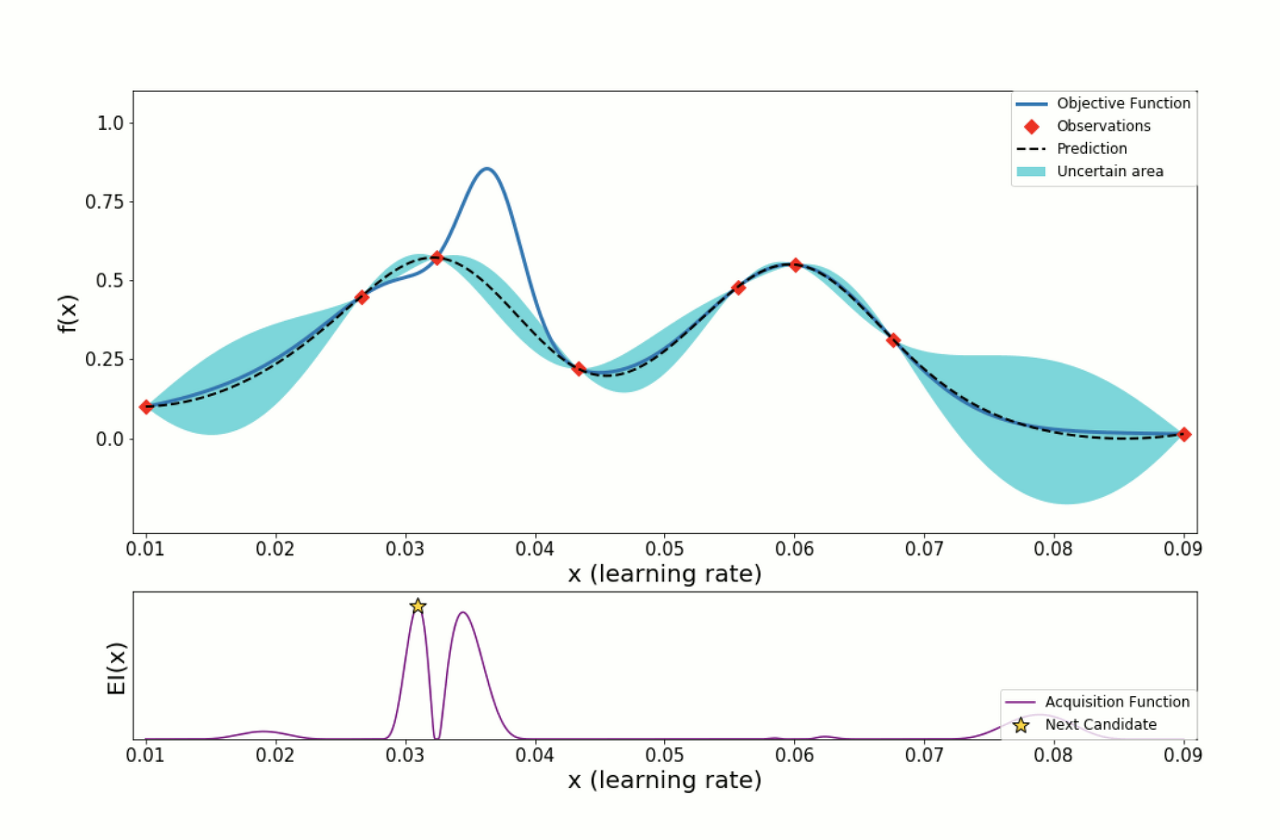

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_validate 
from catboost import CatBoostRegressor
        
X = train_reg.drop('decomposition_energy', axis=1)
y = train_reg['decomposition_energy']

def CB_cv(depth, learning_rate, iterations):
    model = CatBoostRegressor(verbose=False, 
                              random_state=8555,
                              depth = int(depth),   
                              learning_rate=learning_rate,
                              iterations = int(iterations))
    
    scoring = {'r2_score': make_scorer(r2_score)}
    result = cross_validate(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring=scoring)
    result_mean = result["test_r2_score"].mean()
    return result_mean

# 주어진 범위 사이에서 적절한 값을 찾는다.
pbounds={
    'depth': (7,12),
    'learning_rate': (0.01, 0.1),
    'iterations': (800, 1000)
    }

CBBO = BayesianOptimization(f = CB_cv, pbounds = pbounds)

# r2 기준으로 최대화!
CBBO.maximize(init_points=3, n_iter = 10)

print(CBBO.max) # 찾은 파라미터 값 확인

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
|  1        |  0.7506   |  9.492    |  889.1    |  0.04828  |
|  2        |  0.751    |  7.726    |  949.6    |  0.05361  |
|  3        |  0.6921   |  8.278    |  805.0    |  0.0156   |
|  4        |  0.7322   |  7.513    |  948.1    |  0.05576  |
|  5        |  0.7527   |  8.076    |  952.2    |  0.06608  |
|  6        |  0.7347   |  11.9     |  950.7    |  0.02405  |
|  7        |  0.7511   |  10.38    |  885.0    |  0.04532  |
|  8        |  0.7471   |  7.0      |  886.1    |  0.1      |
|  9        |  0.7366   |  8.776    |  880.4    |  0.044    |
|  10       |  0.7503   |  7.22     |  893.4    |  0.06412  |
|  11       |  0.7255   |  11.75    |  893.2    |  0.02116  |
|  12       |  0.6562   |  7.0      |  890.2    |  0.01     |
|  13       |  0.7161   |  7.397    |  952.2    |  0.03929  |
{'target': 0.7526680045623421, 'params': {'depth': 8.076394862379733, 

In [ ]:
cb_bo_model = CatBoostRegressor(
                            verbose=False,
                            random_state=8555,                         
                            depth = int(CBBO.max['params']['depth']),
                            learning_rate=CBBO.max['params']['learning_rate'],
                            iterations = int(CBBO.max['params']['iterations']))

### Regression tunning 결과

- BayesianOptimization으로 진행한 것이 제일 좋은 결과로 나왔다.
- pycaret으로 그래프를 그리기 위해 베이지안 옵티마이제이션을 적용한 catboost를 pycaret을 통해 만든다.


In [ ]:
bo_cb_py = regression.create_model(
                        'catboost',
                        depth= 8,
                        iterations = 952,
                        learning_rate = 0.06607976267302655,
                        loss_function = 'RMSE',
                        random_state = 8555)

MAE     MSE    RMSE      R2   RMSLE          MAPE
0     0.1006  0.0316  0.1777  0.7511  0.1129  4.259987e+11
1     0.1124  0.0429  0.2072  0.6572  0.1216  6.309503e+10
2     0.1129  0.0378  0.1945  0.7081  0.1219  2.508600e+00
3     0.1090  0.0404  0.2010  0.6834  0.1235  4.325000e+00
4     0.1127  0.0396  0.1990  0.6890  0.1175  1.354181e+11
Mean  0.1095  0.0385  0.1959  0.6978  0.1195  1.249024e+11
SD    0.0047  0.0038  0.0100  0.0312  0.0038  1.586133e+11

### Regression 모델 시각화 
- CatBoostRegressor 시각화 (pycaret 제공 시각화 그래프)
- (왜 Test r2 스코어가 저런지는 모르겠음니다)

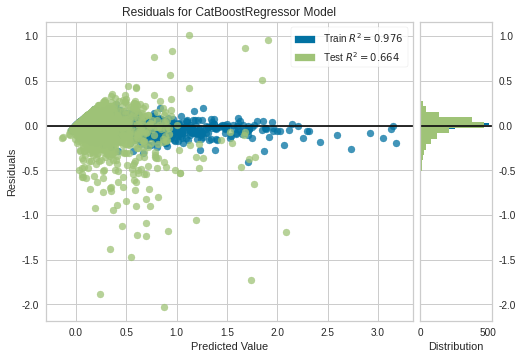

In [ ]:
regression.plot_model(bo_cb_py)

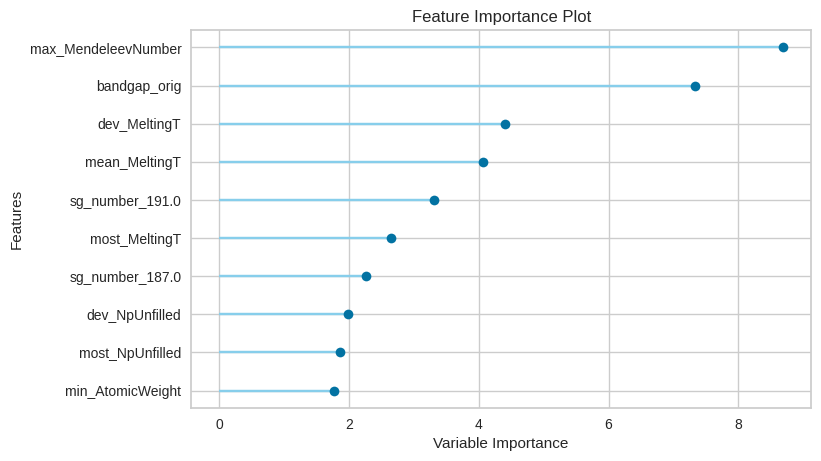

In [ ]:
regression.plot_model(bo_cb_py, plot = 'feature')

### Regression test set 예측

In [ ]:
reg_final_cb = cb_bo_model # BayesianOptimization 모델을 사용

In [ ]:
X = train_reg.drop('decomposition_energy', axis=1)
y = train_reg['decomposition_energy']

reg_final_cb.fit(X, y)
y_reg = reg_final_cb.predict(test)

y_reg

array([ 6.87391120e-01,  2.36498983e-01,  2.33872386e-01,  1.07508042e-01,
        2.52566189e-01,  3.82475856e-01,  1.81832353e-01,  1.91491751e-01,
        7.30838385e-02, -2.26224586e-02,  3.62934677e-01,  6.87359863e-01,
        6.92008274e-01,  1.41191299e-01,  1.43889539e-01,  3.22572965e-01,
        3.17546955e-01,  1.34006256e-01,  1.35876350e-01,  1.70756126e-01,
        1.30698020e+00,  9.13870712e-02,  7.46430631e-01,  1.29715571e-01,
        5.44838055e-01,  1.20527619e-01,  1.71509246e-01,  2.56779007e-01,
        1.86538699e-01,  3.15197441e-01, -1.47192603e-02,  9.00332048e-01,
        2.31963908e-01,  1.47158513e-02,  7.62965937e-02,  8.20948432e-02,
        2.97276458e-01, -1.57652046e-02,  1.69864157e-01,  1.72370102e-01,
        1.02154290e+00,  3.21362440e-02,  7.21484950e-02,  1.54442089e-01,
        4.70872625e-02,  7.62615393e-02,  8.80702057e-02,  4.11516815e-02,
        3.83882500e-01,  2.36633438e-01,  2.04209712e-02, -2.01780218e-02,
        1.49786950e-01,  

## 제출파일로 변환

In [ ]:
submission =  pd.read_csv('/content/drive/MyDrive/인공지능/Test_set_Unlabled.csv')
submission['crystal_system'] = y_cls
submission['decomposition_energy'] = y_reg
submission

Index  NComp  Comp_L2Norm  ...  sg_number  crystal_system  decomposition_energy
0        0      2     0.745356  ...        164        trigonal              0.687391
1       10      2     0.824621  ...        123      tetragonal              0.236499
2       20      2     0.745356  ...        164        trigonal              0.233872
3       30      2     0.790569  ...         12      monoclinic              0.107508
4       40      2     0.745356  ...        164        trigonal              0.252566
..     ...    ...          ...  ...        ...             ...                   ...
611   6110      2     0.790569  ...         99      tetragonal              0.192038
612   6120      2     0.707107  ...         67    orthorhombic              0.671134
613   6130      2     0.790569  ...         99      tetragonal              0.486324
614   6140      2     0.745356  ...         12      monoclinic              0.619072
615   6150      2     0.707107  ...        156        trigonal              0.197794

[616 rows x 150 columns]

In [ ]:
submission.to_csv('/content/drive/MyDrive/인공지능/pycaret_final.csv', index=False)

### 제출 결과 : 1위 (총 9팀)
- Classification : acc 100% 
- Regression : R^2 0.682 

- 느낀점
1. pycaret은 모델 생성시에 도움이 많이 되지만 단일로 사용하기엔 score 부분에서 부정확한 부분이 있었다. 
2. AutoML이 발전하고 있지만 당장은 기초 코드를 쓸 수 있는 사람에게 유용할 것이다. 
3. 2D 물성을 통한 예측을 해볼 수 있어서 좋은 경험이었으며, 교수님이 회귀에서 등수를 낼 수 있게 설계하신게 신기했다.
